In [5]:
import pandas as pd
import numpy as np
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# 1. Load dataset
df = pd.read_csv('Diabetes_Final_Data_V2.csv')  # Replace with your actual file path

# 2. Clean column names
df.columns = df.columns.str.strip()

# 3. Define features
categorical_features = [
    "gender", "family_diabetes", "hypertensive",
    "family_hypertension", "cardiovascular_disease",
    "stroke", "age_group"
]
target_col = 'diabetic'

# 4. Handle age_group if necessary
if 'age_group' not in df.columns or df['age_group'].isnull().any():
    df['age_group'] = pd.cut(
        df['age'],
        bins=[0, 30, 45, 60, 100],
        labels=['Young', 'Mid', 'Senior', 'Elderly']
    ).astype(str)

# Convert target variable to numerical (0 and 1)
df[target_col] = df[target_col].map({'Yes': 1, 'No': 0})

# 5. Split features and target
X = df.drop(columns=target_col)
y = df[target_col]

# 6. Preprocessing
numerical_features = [col for col in X.columns if col not in categorical_features]
scaler = StandardScaler()
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer([
    ('num', scaler, numerical_features),
    ('cat', encoder, categorical_features)
])

# Fit preprocessor
preprocessor.fit(X)
X_processed = preprocessor.transform(X)

# Save preprocessor and feature order
joblib.dump(preprocessor, 'preprocessor.pkl')
joblib.dump(X.columns.tolist(), 'feature_order.pkl')

# 7. Apply SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_processed, y)

# 8. Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Create model directory
os.makedirs('models', exist_ok=True)

# 9. Logistic Regression
lr = LogisticRegression(max_iter=500)
lr.fit(X_train, y_train)
joblib.dump(lr, 'models/lr.pkl')

# 10. Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
joblib.dump(rf, 'models/rf.pkl')

# 11. XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
joblib.dump(xgb, 'models/xgb.pkl')

# 12. LightGBM
lgb = LGBMClassifier(random_state=42)
lgb.fit(X_train, y_train)
joblib.dump(lgb, 'models/lgb.pkl')

# 13. Neural Network
nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
nn.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
nn.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=0)
nn.save('models/nn.h5')

print("✅ All models trained and saved successfully using SMOTE.")

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [21:11:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[LightGBM] [Info] Number of positive: 4087, number of negative: 4061
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4164
[LightGBM] [Info] Number of data points in the train set: 8148, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501595 -> initscore=0.006382
[LightGBM] [Info] Start training from score 0.006382


✅ All models trained and saved successfully using SMOTE.


In [6]:
from sklearn.base import BaseEstimator, ClassifierMixin
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib # For loading models and preprocessor

from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier # If you're using sklearn's MLP for NN
from tensorflow.keras.models import Sequential, load_model # If you're using Keras for NN
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from imblearn.over_sampling import SMOTE

# For SHAP and LIME
import shap
import lime
from lime import lime_tabular
from sklearn.base import BaseEstimator, ClassifierMixin # For LIME Keras wrapper

In [12]:
# ... [Previous code remains unchanged until after model training] ...

print("✅ All models trained and saved successfully using SMOTE.")

# Add missing imports for KerasWrapper
from sklearn.base import BaseEstimator, ClassifierMixin

# 14. Prepare data for explanations
# Process entire original dataset for LIME training
X_entire_processed = preprocessor.transform(X)

# Get feature names after preprocessing
num_features = numerical_features
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([num_features, cat_features])

# 15. Create directory for explanations
os.makedirs('explanations/shap', exist_ok=True)
os.makedirs('explanations/lime', exist_ok=True)

# 16. SHAP Explanations
def generate_shap_explanations(model, model_name, X_test, feature_names):
    """Generate SHAP summary plots for a model"""
    plt.figure(figsize=(10, 6))
    
    # Select appropriate explainer
    if isinstance(model, (RandomForestClassifier, XGBClassifier, LGBMClassifier)):
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
    elif isinstance(model, LogisticRegression):
        explainer = shap.LinearExplainer(model, X_test)
        shap_values = explainer.shap_values(X_test)
    else:
        explainer = shap.KernelExplainer(model.predict, shap.kmeans(X_test, 5))
        shap_values = explainer.shap_values(X_test)
    
    # Generate plots
    if isinstance(shap_values, list):  # For classifiers with multiple outputs
        shap_values = shap_values[1]  # Use positive class values
        
    shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)
    plt.title(f'SHAP Summary - {model_name}')
    plt.tight_layout()
    plt.savefig(f'explanations/shap/shap_summary_{model_name}.png', dpi=150)
    plt.close()

# 17. LIME Explanations (using entire dataset)
class KerasWrapper(BaseEstimator, ClassifierMixin):
    """Wrapper for Keras models to use with LIME"""
    def __init__(self, model):
        self.model = model
        
    def predict_proba(self, X):
        return np.hstack([1 - self.model.predict(X), self.model.predict(X)])

def generate_lime_explanations(model, model_name, X_train_processed, X_test_processed, feature_names, class_names):
    """Generate LIME explanations with proper preprocessing"""
    # Wrap Keras model if needed
    if model_name == 'nn':
        model = KerasWrapper(model)
    
    # Create LIME explainer using entire processed dataset
    explainer = lime_tabular.LimeTabularExplainer(
        training_data=X_train_processed,
        feature_names=feature_names,
        class_names=class_names,
        mode='classification',
        discretize_continuous=False
    )
    
    # Generate explanations for 5 random instances
    np.random.seed(42)
    sample_indices = np.random.choice(len(X_test_processed), 5, replace=False)
    
    for i, idx in enumerate(sample_indices):
        exp = explainer.explain_instance(
            data_row=X_test_processed[idx],
            predict_fn=model.predict_proba,
            num_features=10
        )
        
        # Save as HTML
        exp.save_to_file(f'explanations/lime/lime_{model_name}_sample_{i+1}.html')

# 18. Generate explanations for all models
models = {
    'lr': lr,
    'rf': rf,
    'xgb': xgb,
    'lgb': lgb,
    'nn': nn
}

class_names = ['non-diabetic', 'diabetic']

# Create test set for explanations
X_train_explain, X_test_explain, y_train_explain, y_test_explain = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_test_explain_processed = preprocessor.transform(X_test_explain)

for name, model in models.items():
    print(f"Generating SHAP explanations for {name}...")
    generate_shap_explanations(model, name, X_test_explain_processed, all_feature_names)
    
    print(f"Generating LIME explanations for {name}...")
    generate_lime_explanations(
        model=model,
        model_name=name,
        X_train_processed=X_entire_processed,  # Use entire dataset
        X_test_processed=X_test_explain_processed,
        feature_names=all_feature_names,
        class_names=class_names
    )

print("✅ SHAP and LIME explanations generated successfully.")

✅ All models trained and saved successfully using SMOTE.
Generating SHAP explanations for lr...
Generating LIME explanations for lr...
Generating SHAP explanations for rf...


C:\Users\User\AppData\Local\Temp\ipykernel_4764\3651061657.py:41: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\shap\plots\_beeswarm.py:718: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\shap\plots\_beeswarm.py:738: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and sile

Generating LIME explanations for rf...
Generating SHAP explanations for xgb...


C:\Users\User\AppData\Local\Temp\ipykernel_4764\3651061657.py:41: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)


Generating LIME explanations for xgb...
Generating SHAP explanations for lgb...


C:\Users\User\AppData\Roaming\Python\Python312\site-packages\shap\explainers\_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
C:\Users\User\AppData\Local\Temp\ipykernel_4764\3651061657.py:41: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)


Generating LIME explanations for lgb...
Generating SHAP explanations for nn...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMCla

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 0/1088 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

C:\Users\User\AppData\Local\Temp\ipykernel_4764\3651061657.py:41: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\shap\plots\_beeswarm.py:718: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
✅ SHAP and LIME explanations generated successfully.


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [13]:
explainer = shap.Explainer(xgb)
shap_values = explainer.shap_values(X_test)

C:\Users\User\AppData\Local\Temp\ipykernel_4764\2940161786.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


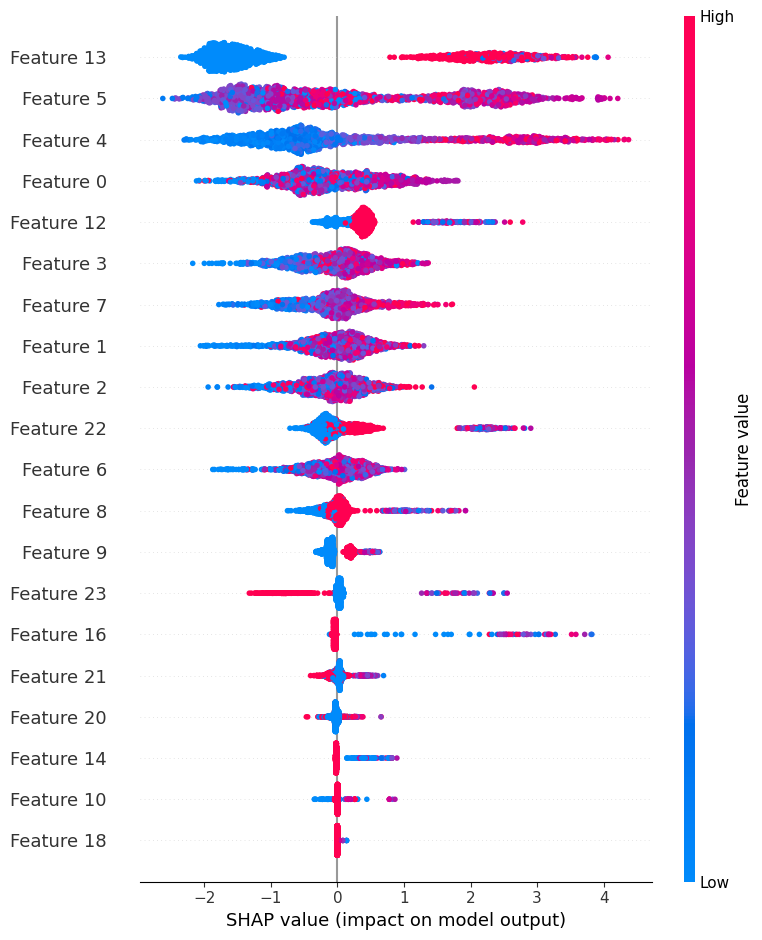

In [14]:
shap.summary_plot(shap_values, X_test)

C:\Users\User\AppData\Local\Temp\ipykernel_4764\2940161786.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


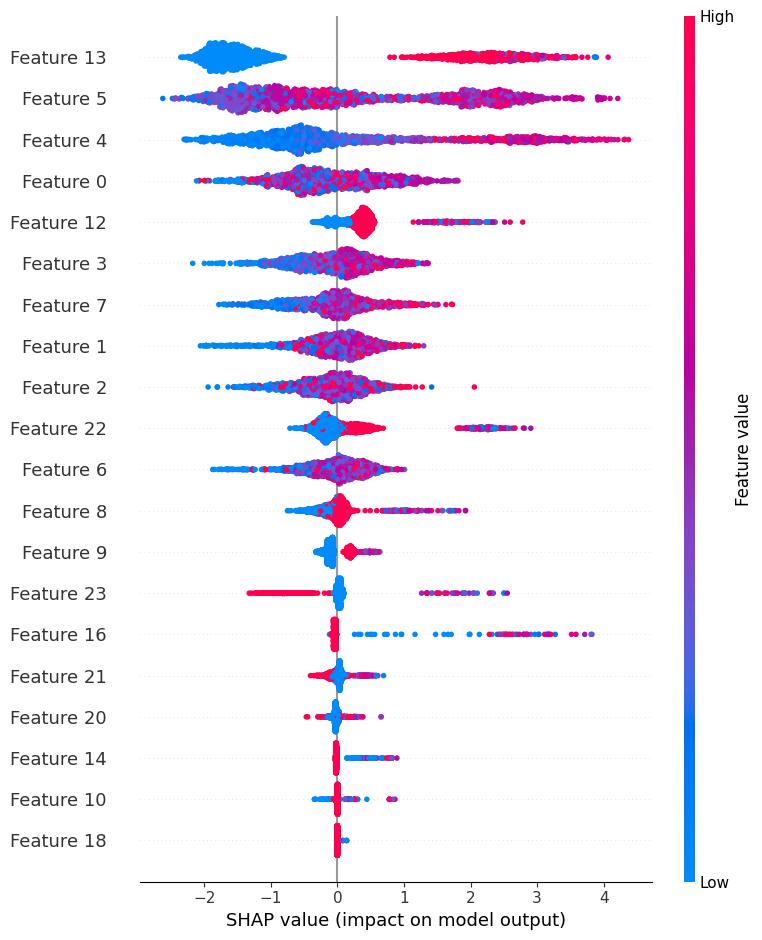

In [16]:
shap.summary_plot(shap_values, X_test)

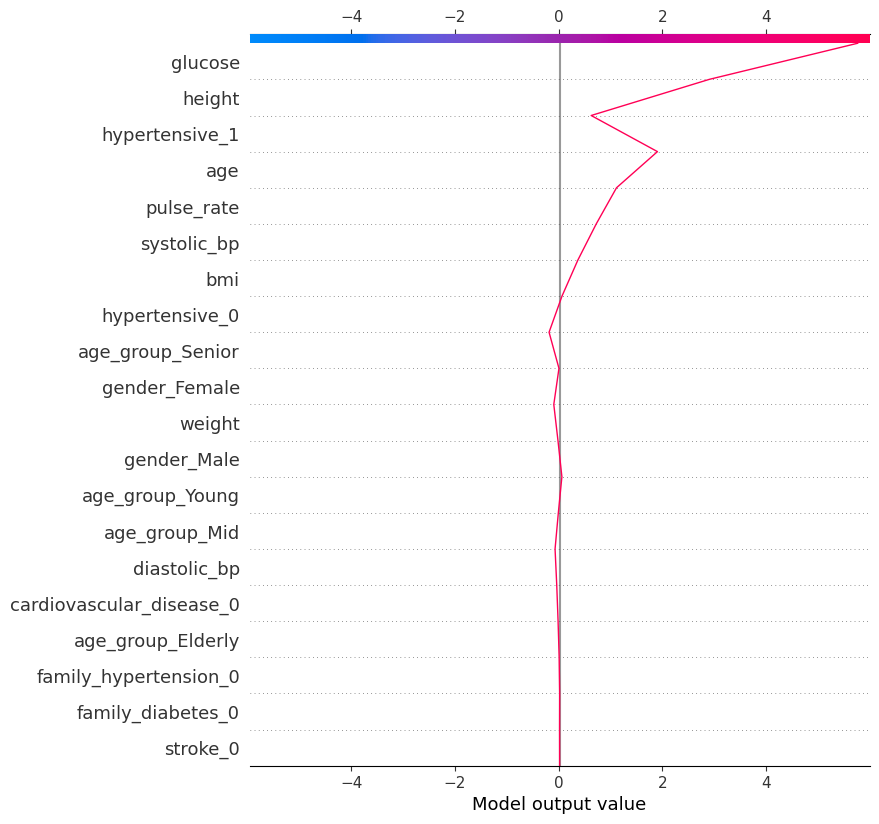

In [33]:
shap.decision_plot(explainer.expected_value, shap_values[1], all_feature_names)

In [34]:
from sklearn.inspection import PartialDependenceDisplay

for feature in top_features:
    PartialDependenceDisplay.from_estimator(
        model, X_test_processed, [feature], 
        feature_names=all_feature_names
    ).plot()
    plt.savefig(f'explanations/pdp/{name}_{feature}.png')

NameError: name 'top_features' is not defined

In [7]:
# ... [Previous code remains unchanged until after model training] ...

print("✅ All models trained and saved successfully using SMOTE.")

# Add missing imports for enhanced visualizations
from sklearn.base import BaseEstimator, ClassifierMixin
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

# 14. Prepare data for explanations
# Process entire original dataset for LIME training
X_entire_processed = preprocessor.transform(X)

# Get feature names after preprocessing
num_features = numerical_features
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([num_features, cat_features])

# 15. Create directory for enhanced explanations
os.makedirs('explanations/shap', exist_ok=True)
os.makedirs('explanations/lime', exist_ok=True)
os.makedirs('explanations/feature_importance', exist_ok=True)

# 16. Enhanced SHAP Explanations
def generate_shap_explanations(model, model_name, X_test, feature_names):
    """Generate enhanced SHAP visualizations"""
    # Select appropriate explainer
    if isinstance(model, (RandomForestClassifier, XGBClassifier, LGBMClassifier)):
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
    elif isinstance(model, LogisticRegression):
        explainer = shap.LinearExplainer(model, X_test)
        shap_values = explainer.shap_values(X_test)
    else:
        explainer = shap.KernelExplainer(model.predict, shap.kmeans(X_test, 5))
        shap_values = explainer.shap_values(X_test)
    
    # Handle binary classification output
    if isinstance(shap_values, list) and len(shap_values) == 2:
        shap_values = shap_values[1]  # Use positive class values
    
    # 1. Summary Plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)
    plt.title(f'SHAP Summary - {model_name}', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'explanations/shap/shap_summary_{model_name}.png', dpi=150, bbox_inches='tight')
    plt.close()
    
    # 2. Bar Plot of Mean Absolute SHAP Values
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="bar", show=False)
    plt.title(f'SHAP Feature Importance - {model_name}', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'explanations/shap/shap_bar_{model_name}.png', dpi=150, bbox_inches='tight')
    plt.close()
    
    # 3. Waterfall Plot for a Representative Sample
    sample_idx = np.random.randint(0, len(X_test))
    plt.figure(figsize=(14, 8))
    shap.waterfall_plot(explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value, 
                        shap_values[sample_idx], 
                        features=X_test[sample_idx], 
                        feature_names=feature_names,
                        show=False)
    plt.title(f'SHAP Waterfall Plot - {model_name} (Sample {sample_idx})', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'explanations/shap/shap_waterfall_{model_name}.png', dpi=150, bbox_inches='tight')
    plt.close()
    
    # 4. Decision Plot for Multiple Samples
    sample_indices = np.random.choice(len(X_test), min(5, len(X_test)), replace=False)
    plt.figure(figsize=(14, 10))
    shap.decision_plot(explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value, 
                      shap_values[sample_indices], 
                      features=X_test[sample_indices],
                      feature_names=feature_names,
                      show=False)
    plt.title(f'SHAP Decision Plot - {model_name}', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'explanations/shap/shap_decision_{model_name}.png', dpi=150, bbox_inches='tight')
    plt.close()

# 17. Enhanced LIME Explanations
class KerasWrapper(BaseEstimator, ClassifierMixin):
    """Wrapper for Keras models to use with LIME"""
    def __init__(self, model):
        self.model = model
        
    def predict_proba(self, X):
        return np.hstack([1 - self.model.predict(X), self.model.predict(X)])

def generate_lime_explanations(model, model_name, X_train_processed, X_test_processed, feature_names, class_names):
    """Generate enhanced LIME explanations"""
    # Wrap Keras model if needed
    if model_name == 'nn':
        model = KerasWrapper(model)
    
    # Create LIME explainer using entire processed dataset
    explainer = lime_tabular.LimeTabularExplainer(
        training_data=X_train_processed,
        feature_names=feature_names,
        class_names=class_names,
        mode='classification',
        discretize_continuous=False,
        verbose=True
    )
    
    # Generate explanations for representative samples
    sample_indices = np.random.choice(len(X_test_processed), 5, replace=False)
    
    for i, idx in enumerate(sample_indices):
        # Generate explanation
        exp = explainer.explain_instance(
            data_row=X_test_processed[idx],
            predict_fn=model.predict_proba,
            num_features=10,
            top_labels=1
        )
        
        # Save as HTML
        exp.save_to_file(f'explanations/lime/lime_{model_name}_sample_{i+1}.html')
        
        # Save as PNG image
        fig = exp.as_pyplot_figure()
        fig.set_size_inches(12, 8)
        plt.title(f'LIME Explanation - {model_name} (Sample {i+1})', fontsize=14)
        plt.tight_layout()
        plt.savefig(f'explanations/lime/lime_{model_name}_sample_{i+1}.png', dpi=150, bbox_inches='tight')
        plt.close()

# 18. Permutation Importance
def generate_permutation_importance(model, model_name, X_test, y_test, feature_names):
    """Calculate and plot permutation importance"""
    if model_name == 'nn':
        # Wrap Keras model for sklearn compatibility
        def predict_wrapper(X):
            return model.predict(X, verbose=0).flatten()
    else:
        predict_wrapper = model.predict_proba
    
    # Calculate permutation importance
    result = permutation_importance(
        model, X_test, y_test, n_repeats=10, random_state=42, 
        scoring='roc_auc', n_jobs=-1
    )
    
    # Sort features by importance
    sorted_idx = result.importances_mean.argsort()
    
    # Plot
    plt.figure(figsize=(14, 10))
    plt.boxplot(
        result.importances[sorted_idx].T,
        vert=False, 
        labels=np.array(feature_names)[sorted_idx]
    )
    plt.title(f'Permutation Importance - {model_name}', fontsize=14)
    plt.xlabel('Decrease in ROC AUC')
    plt.tight_layout()
    plt.savefig(f'explanations/feature_importance/perm_importance_{model_name}.png', dpi=150, bbox_inches='tight')
    plt.close()

# 19. Generate all explanations for each model
models = {
    'lr': lr,
    'rf': rf,
    'xgb': xgb,
    'lgb': lgb,
    'nn': nn
}

class_names = ['non-diabetic', 'diabetic']

# Create test set for explanations
X_train_explain, X_test_explain, y_train_explain, y_test_explain = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_test_explain_processed = preprocessor.transform(X_test_explain)

for name, model in models.items():
    print(f"Generating enhanced SHAP explanations for {name}...")
    generate_shap_explanations(model, name, X_test_explain_processed, all_feature_names)
    
    print(f"Generating enhanced LIME explanations for {name}...")
    generate_lime_explanations(
        model=model,
        model_name=name,
        X_train_processed=X_entire_processed,
        X_test_processed=X_test_explain_processed,
        feature_names=all_feature_names,
        class_names=class_names
    )
    
    print(f"Generating permutation importance for {name}...")
    generate_permutation_importance(
        model, 
        name, 
        X_test_explain_processed, 
        y_test_explain, 
        all_feature_names
    )

print("✅ Enhanced SHAP, LIME, and permutation importance explanations generated successfully.")

✅ All models trained and saved successfully using SMOTE.
Generating enhanced SHAP explanations for lr...


TypeError: waterfall() got an unexpected keyword argument 'features'

<Figure size 1400x800 with 0 Axes>